In [58]:
'''
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
'''

import matplotlib.pyplot as plt
import os
import sys
import preprocessor
import preprocessor_for_dual_model
import svdd
import Dual_Autoencoder_MultiFilter as dual_model
import Autoencoder as au_model
import Autoencoder_MultiFilter as au_multi_model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pims
import time
import matplotlib.animation as animation

import numpy as np

# Get DATA

In [2]:
TRAIN_PATH = "UCSD/UCSDped2/Train/"
TEST_PATH = "UCSD/UCSDped2/Test/"

### Get train data

In [3]:
X_train, X_val = preprocessor.get_data_train_and_val(TRAIN_PATH, n_sets_use=8)

1128
(1016, 227, 227, 9, 1) (112, 227, 227, 9, 1)


In [5]:
X_train, X_val, X_train_opflow, X_val_opflow = preprocessor_for_dual_model.get_data_train_and_val(TRAIN_PATH, n_sets_use=1)

145
(131, 227, 227, 5, 1) (14, 227, 227, 5, 1) (131, 227, 227, 5, 3) (14, 227, 227, 5, 3)


In [ ]:
X_train, X_val= [], []

### Get test data

In [ ]:
#X_test, y_test_gt, X_test_opflow = preprocessor_for_dual_model.get_data_test(TEST_PATH, n_sets_use=1)
X_test, y_test_gt = preprocessor.get_data_test(TEST_PATH, n_sets_use=1)

Test001
Test001_gt
171
Test001
Test001_gt


In [ ]:
y_test_gt_0 = y_test_gt.copy()
y_test_gt_0[y_test_gt_0 == -1] = 0

In [ ]:
X_test, y_test_gt = [], []

# Define Adversarial Autoencoders GAN model

In [4]:
img_row = 227
img_col = 227
channel = 1
img_len = 9
is_Dual = False

In [5]:
dcgan = au_model.Autoencoder(img_row, img_col, channel, img_len)

Autoencoder model summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 227, 227, 9, 1)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 55, 55, 9, 128)    15616     
_________________________________________________________________
batch_normalization_1 (Batch (None, 55, 55, 9, 128)    512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 55, 55, 9, 128)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 26, 26, 9, 64)     204864    
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 9, 64)     256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 26, 26, 9, 64)

In [ ]:
dcgan.train(1, X_train, X_val, X_test, batch_size=1)

### Save and Load

In [ ]:
dcgan.save_model()

In [6]:
dcgan.load_model()

In [ ]:
print(dcgan.autoencoder.evaluate(X_train, X_train, batch_size=4, verbose=1))

# Resconstruction Scoring

### Scoring

In [ ]:
res_train = []
for i in range(X_train.shape[0]):
    if (is_Dual):
        res_train.append(dcgan.autoencoder.evaluate(X_train[i:i+1], X_train_opflow[i:i+1],verbose=0)\
                        +dcgan.auto_opflow.evaluate(X_train_opflow[i:i+1], X_train[i:i+1], verbose=0))
    else:
        res_train.append(dcgan.autoencoder.evaluate(X_train[i:i+1], X_train[i:i+1],verbose=0))

e_min = min(res_train)
e_max = max(res_train)
print(e_min, e_max)

In [ ]:
score_test = []
for i in range(X_test.shape[0]):
    if (is_Dual):
        err = dcgan.autoencoder.evaluate(X_test[i:i+1], X_test_opflow[i:i+1],verbose=0) \
            + dcgan.auto_opflow.evaluate(X_test_opflow[i:i+1], X_test[i:i+1],verbose=0)
    else:
        err = dcgan.autoencoder.evaluate(X_test[i:i+1], X_test[i:i+1],verbose=0)
        
    score_test.append(1 - (err-e_min) / e_max)

### Reconstruction ROC/AUC

In [ ]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_gt_0, score_test)
print(fpr_keras, tpr_keras)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Latent output for train and test for SVDD learning

In [7]:
out_train = dcgan.encoder.predict(X_train, batch_size=4, verbose=1)
#out_test = dcgan.encoder.predict(X_test, batch_size=4, verbose=1)
if (is_Dual):
    out_train_opflow = dcgan.encoder_opflow.predict(X_train_opflow, batch_size=4, verbose=1)
    #out_test_opflow = dcgan.encoder_opflow.predict(X_test_opflow, batch_size=4, verbose=1)

1016/1016 [==============================] - 20s 20ms/step


In [8]:
out_train = out_train.reshape(len(out_train), -1)
#out_test = out_test.reshape(len(out_test), -1)
if (is_Dual):
    out_train_opflow = out_train_opflow.reshape(len(out_train_opflow), -1)
    #out_test_opflow = out_test_opflow.reshape(len(out_test_opflow), -1)

In [ ]:
if (is_Dual):
    out_train = np.concatenate((out_train, out_train_opflow), axis=1)
    #out_test = np.concatenate((out_test, out_test_opflow), axis=1)

In [ ]:
np.save('Saved_Data/Train_Vector_Peds1.npy', out_train)
np.save('Saved_Data/Test_Vector_Peds1.npy', out_test)

In [ ]:
out_train = np.load('Saved_Data/Train_Vector_Peds1.npy')
#out_test = np.load('Saved_Data/Test_Vector_Peds1.npy')

In [9]:
print(out_train.shape)#, out_test.shape)

(1016, 18432)


In [ ]:
out_train, out_test = [], []

# Visualize feature vectors using PCA to down scale

In [ ]:
X_train_PCA = out_train
X_test_PCA = out_test

In [ ]:
pca = PCA(n_components=2)
X_train_PCA = pca.fit_transform(X_train_PCA)
X_test_PCA = pca.transform(X_test_PCA)

In [ ]:
X_test_PCA_normal = X_test_PCA[y_test_gt==1]
X_test_PCA_abnormal = X_test_PCA[y_test_gt==-1]

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.scatter(X_train_PCA[:,0], X_train_PCA[:,1], cmap='Blues')
ax.scatter(X_test_PCA_normal[:,0], X_test_PCA_normal[:,1], cmap='Greens')
ax.scatter(X_test_PCA_abnormal[:,0], X_test_PCA_abnormal[:,1], cmap='Greens')

# SVDD

### Learning SVDD

In [10]:
X_train_PCA = out_train
#X_test_PCA = out_test

In [11]:
pca = PCA(n_components=3)
X_train_PCA = pca.fit_transform(X_train_PCA)
#X_test_PCA = pca.transform(X_test_PCA)

In [12]:
n_clusters = 4

In [13]:
labels = KMeans(n_clusters=n_clusters,verbose=0).fit(X_train_PCA).labels_

In [14]:
clf = []
for i in range(n_clusters):
    clf_t = svdd.train_svdd(X_train_PCA[labels==i], outlier_fraction=0.001, kernel_s=10.0)
    clf.append(clf_t)    

center of each SVDD :  [-0.73754045  0.70972852 -4.51483689]
best radius of each SVDD :  [0.36692931]
number support vector:  4
center of each SVDD :  [9.7723338  4.25947942 1.03114626]
best radius of each SVDD :  [0.50545661]
number support vector:  6
center of each SVDD :  [10.67235638 -3.93580996 -0.94452737]
best radius of each SVDD :  [0.51309614]
number support vector:  6
center of each SVDD :  [-7.00941975 -1.00966758  2.61094014]
best radius of each SVDD :  [0.22050784]
number support vector:  3


In [15]:
y_train = np.full(len(X_train_PCA), -1)

In [16]:
for i in range(n_clusters):
    y_train[y_train==-1] = clf[i].predict(X_train_PCA[y_train==-1])
    #y_train[y_train==-1] = clf[i].predict(result_train[y_train==-1])    

In [17]:
len(y_train[y_train==1]) / len(y_train)

0.9872047244094488

In [19]:
y_test = np.full(len(X_test_PCA), 0.0)

In [20]:
for i in range(X_test_PCA.shape[0]):
    scr = []
    for j in range(n_clusters):
        scr.append(clf[j].decision_function(X_test_PCA[i:i+1]))
    max_val = max(scr)
    y_test[i] = max(0, max_val)
    #y_test[i] = max_val

In [21]:
e_min = min(y_test)
e_max = max(y_test)
print(e_min, e_max)

0.0 0.09162983214343068


In [22]:
y_test = (y_test - e_min) / (e_max + 0.00001)

### SVDD classification AUC/ROC

In [26]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_gt, y_test)
print(fpr_keras, tpr_keras)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

[0.         0.         0.00840336 0.00840336 0.01680672 0.01680672
 0.02521008 0.02521008 0.03361345 0.03361345 0.05882353 0.05882353
 0.06722689 0.06722689 0.07563025 0.07563025 0.09243697 0.09243697
 0.10084034 0.10084034 0.11764706 0.11764706 0.12605042 0.12605042
 0.14285714 0.14285714 0.20168067 0.20168067 0.23529412 0.23529412
 0.26890756 0.26890756 0.30252101 0.30252101 0.31092437 0.31092437
 0.38655462 0.38655462 0.42857143 0.42857143 0.46218487 0.46218487
 0.50420168 0.50420168 0.51260504 0.51260504 0.8487395  1.        ] [0.01923077 0.11538462 0.11538462 0.13461538 0.13461538 0.46153846
 0.46153846 0.48076923 0.48076923 0.5        0.5        0.53846154
 0.53846154 0.57692308 0.57692308 0.61538462 0.61538462 0.63461538
 0.63461538 0.67307692 0.67307692 0.69230769 0.69230769 0.75
 0.75       0.76923077 0.76923077 0.80769231 0.80769231 0.82692308
 0.82692308 0.84615385 0.84615385 0.86538462 0.86538462 0.88461538
 0.88461538 0.92307692 0.92307692 0.94230769 0.94230769 0.96153846


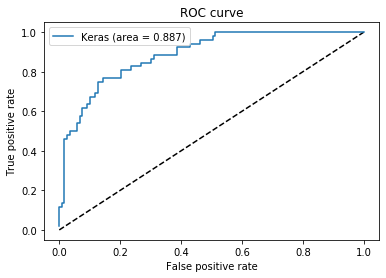

In [27]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Test model

In [48]:
def update(num, x, y, line):
    line.set_data(x[:num], y[:num])
    line.axes.axis([0, 200, 0, 1])
    return line,

In [62]:
def test_model(PATH, folder_name, dcgan, svdd, pca, use_gt=True):
    test_folder = folder_name
    n_clusters = len(svdd)
    if (use_gt==True):
        gt_folder = test_folder + '_gt'
    
    img_seq = pims.ImageSequence(PATH + test_folder + '/*.tif')
    img_seq = np.asarray(preprocessor.normalize_image(list(img_seq)))
    img_seq = np.expand_dims(img_seq, axis=3)
    img_seq = np.expand_dims(img_seq, axis=0)

    if (use_gt):
        if (gt_folder in os.listdir(PATH)):
            gt_seq = pims.ImageSequence(PATH + gt_folder + '/*.bmp')
            gt_seq = np.asarray(preprocessor.normalize_image(list(gt_seq)))
            gt_seq = np.expand_dims(gt_seq, axis=3)
            gt_seq = np.expand_dims(gt_seq, axis=0)
        else:
            gt_seq = np.zeros(img_seq.shape)
    else:
        gt_seq = np.zeros(img_seq.shape)
    
    if (use_gt): 
        test_seq, test_gt = preprocessor.create_data_test(img_seq, gt_seq)
        print(test_seq.shape, test_gt.shape)
    else:
        test_seq, _ = preprocessor.create_data_test(img_seq, gt_seq)

    idx = list(range(test_seq.shape[0]))
    fig = plt.figure(figsize=(5,5))
    img = None
    time_plot = None
    gt_plot = None
    pred_plot = None
    acc_plot = None
    acc = 0.0
    e_min, e_max = None, None
    
    if (use_gt):
        vect = dcgan.encoder.predict(test_seq, batch_size=4)
        vect = np.reshape(vect, (len(vect),-1))
        vect = pca.transform(vect)
        score = np.full(test_seq.shape[0], 0.0)
        for i in range(test_seq.shape[0]):
            scr = []
            for j in range(n_clusters):
                scr.append(svdd[j].decision_function(vect[i:i+1]))
            max_val = max(scr)
            score[i] = max(0, max_val)
        e_min, e_max = min(score), max(score)
        print(e_min, e_max)

    for i in range(test_seq.shape[0]):
        start = time.time()

        vect = dcgan.encoder.predict(test_seq[i:i+1])
        vect = np.reshape(vect, (len(vect),-1))
        vect = pca.transform(vect)
        pred = -1
        for j in range(n_clusters):
            pred = svdd[j].predict(vect[0:1])
            if (pred == 1):
                break
            
        if (use_gt == True):
            scr = []
            for j in range(n_clusters):
                scr.append(svdd[j].decision_function(vect[0:1]))
            max_val = max(scr)
            max_scr = (max_val - e_min) / e_max
            score[i] = max_scr
            gtr = test_gt[i]
            if (i != 0):
                fpr_keras, tpr_keras, _ = roc_curve(test_gt[:i+1], score[:i+1])
                auc_keras = auc(fpr_keras, tpr_keras)
            else:
                auc_keras = 0
        run_time = time.time() - start

        im=test_seq[i,:,:,0,0]
        te='Time: ' + str(round(run_time,3))
        pr='Prediction: ' + str(pred)
        if (use_gt):
            gt='Gound truth: ' + str(gtr)
            ac='AUC score: ' + str(round(auc_keras,3))

        if img is None:
            fig, axx = plt.subplots(3)
            
            img = axx[0].imshow(im, cmap='gray')

            gt_plot = axx[1].text(0.5, 0.4, gt, horizontalalignment='center', verticalalignment='center')
            pred_plot = axx[1].text(0.5, 0.5, pr, horizontalalignment='center', verticalalignment='center')
            acc_plot = axx[1].text(0.5, 0.6, ac, horizontalalignment='center', verticalalignment='center')
            time_plot = axx[1].text(0.5, 0.7, te, horizontalalignment='center', verticalalignment='center')
            
            line, = axx[2].plot(score, idx, color='k')
        else:
            img.set_data(im)
            pred_plot.set_text(pr)
            if (use_gt):
                gt_plot.set_text(gt)
                acc_plot.set_text(ac)
            time_plot.set_text(te)
            ani = animation.FuncAnimation(fig, update, len(score), fargs=[idx, score, line],
                              interval=25, blit=True)

        plt.pause(.01)
        plt.draw()

In [63]:
%matplotlib qt

In [64]:
test_model(TEST_PATH, 'Test007', dcgan, clf, pca, True)

(171, 227, 227, 9, 1) (171,)
0.0 0.10187956057471015


C:\Users\ADMIN\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\ADMIN\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


KeyboardInterrupt: 

KeyboardInterrupt: 